# Saliency maps
Tutorial from [here](https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4). First import stuff

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
# from torchsummary import summary NOTE not known
import requests
from PIL import Image
import os

#Using VGG-19 pretrained model for image classification
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

Download photo to work from [git](https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02123394_Persian_cat.JPEG) that is an imagenet example

In [2]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)

# path for the downloaded images
imagePath = "../data/downloaded_pics/input.jpg"
imageDirectory = "../data/downloaded_pics/"

# Check whether the directory exists
if not os.path.exists(imageDirectory):
        os.mkdir(imageDirectory)
        print("A new directory 'downloaded_pics' was created under 'data'.")
else:
        print("Directory already exists.")
             
# Downloading the image    
download(
        "https://www.losanimales.org/wp-content/uploads/2018/03/Bulldog-Ingles.jpg",
        imagePath)

# Opening the image
img = Image.open(imagePath) 

Directory already exists.


Preseccing of the image. Normalising, rearange range of image, and converting to tensor

In [3]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

Creating the saliency map.

In [4]:
# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]


'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency_mean = torch.mean(X.grad.data, dim=1)
saliency_max, _ = torch.max(X.grad.data, dim=1)
saliency_mean_abs = torch.mean(X.grad.data.abs(), dim=1) #torch.max(X.grad.data.abs(),dim=1)
saliency_max_abs, _ = torch.max(X.grad.data.abs(), dim=1)



In [5]:
gradData = X.grad.data
print(f"the dimension before absolute value: {gradData.size()}")
print(f"The dimension after absolute value: {gradData.abs().size()}")
print(f"The dimension after mean-function: {saliency_mean.size()}")


the dimension before absolute value: torch.Size([1, 3, 224, 224])
The dimension after absolute value: torch.Size([1, 3, 224, 224])
The dimension after mean-function: torch.Size([1, 224, 224])


Plot stuff

Text(0.5, 1.0, 'Channel max')

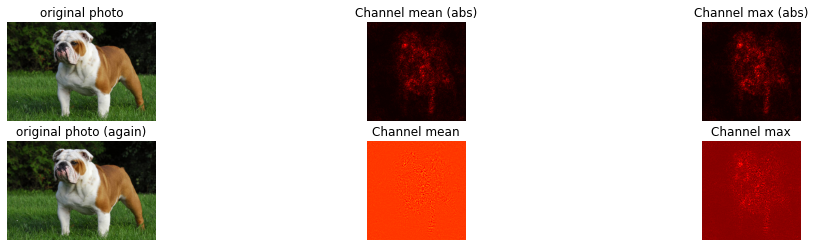

In [6]:
fig1=plt.figure(figsize=(17,4))
plt.subplot(2,3,1)
plt.imshow(img)
plt.axis('off')
plt.title('original photo')

plt.subplot(2,3,2)
plt.imshow(saliency_mean_abs[0], cmap=plt.cm.hot)
plt.axis('off')
plt.title('Channel mean (abs)')

plt.subplot(2,3,3)
plt.imshow(saliency_max_abs[0], cmap=plt.cm.hot)
plt.axis('off')
plt.title('Channel max (abs)')

plt.subplot(2, 3, 4)
plt.imshow(img)
plt.axis('off')
plt.title('original photo (again)')

plt.subplot(2,3,5)
plt.imshow(saliency_mean[0], cmap=plt.cm.hot)
plt.axis('off')
plt.title('Channel mean')

plt.subplot(2,3,6)
plt.imshow(saliency_max[0], cmap=plt.cm.hot)
plt.axis('off')
plt.title('Channel max')

